# Code for "Electrical Flows over Spanning Trees"

In [11]:
import string
import numpy as np
import os
import ast
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
from scipy.sparse.linalg import spsolve
import datetime
import pandas as pd
import os
import zipfile
from functools import reduce
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np

alpha = list(string.ascii_lowercase)[:-1]

## Creating Graph Instances 

In [50]:
def grid(size):
    
    '''
    Function that creates a square grid graph
    '''
    
    grid = nx.grid_2d_graph(size, size)
    mapping = {}
    j = 1
    for i in sorted(grid.nodes()):
        mapping[i] = j
        j += 1
    graph = nx.relabel_nodes(grid,mapping)
    
    return graph


def create_grid(graph, source, demand,p,plist):
    
    
    '''
    Function that takes problem inputs and returns data in desired format to run the algorithms in paper.
    
    The inputs are a generic square grid graph, a demand dictionary for each node, sparsification probability,
    and a dictionary with the probability of each edge being deleted from the graph. 
    
    It returns the sparsified graph, the demand vectors in required formats
    '''
    
    #sparsify graph
    
    #find potential list of edges to be deleted
    edges_to_be_deleted = []
    for e in graph.edges():
        if plist[e] <= p:
            edges_to_be_deleted.append(e)
            
    #only delete edges if they do not disconnect the graph        
    for u,v in edges_to_be_deleted:
        graph.remove_edge(u,v)
        if nx.is_connected(graph):
            continue
        else:
            graph.add_edge(u,v)


    #find demand of source and generate dictionary of demands
    d_s = sum(demand.values())
    b = {}
    for i in graph.nodes():
        if i == source:
            b[i] = d_s
        else:
            b[i] = -demand[i]
            
    return graph, b

## Gurobi Code to Compute Flow relaxation and Optimal Tree

In [37]:
def relaxed_flow(b, G):
    
    '''
    Function to compute flow relaxation. It takes in the b vector obtained from create_grid function and dicitonary 
    with graph edges and their resistances, and returns flow relaxation.
    '''
    
    now=datetime.datetime.now()
    
    # Create model
    m = Model("min-cost flow")

    n = len(b)

    #add one variable for every edge
    f = {}
    for k,v in G.items():
        f[k] = m.addVar(lb=-GRB.INFINITY, name='f_{},{}'.format(k[0], k[1]))
    m.update()

    objExp = quicksum([G[k]*f[k]*f[k] for k in G.keys()])
    m.setObjective(objExp, GRB.MINIMIZE)
    m.update()

    #add constraints

    #generate constraint for each node
    expr={}
    rhs={}
    for i in b.keys():
        expr[i] = LinExpr()

    #balance flow equations
    for k,v in G.items():
        expr[k[0]].add(f[k],1)
        expr[k[1]].add(f[k],-1)

    #set balance flow constraint
    for i in b.keys():
        m.addConstr(expr[i], '=', b[i])    

    m.update()

    #write the model
    m.write("minCostFlow_relax.lp")

    #optimize
    m.setParam( 'OutputFlag', False )
    m.optimize()
    
    sol = {}
    for k,v in f.items():
        sol[k] = v.x
        
    later=datetime.datetime.now()
    time= (later - now).total_seconds()

    return sol, m.objVal,time


def exact_tree_ext(b,G, graph):
    
    
    '''
    Function to compute optimal spanning tree using Martin's Extended Formulation. 
    
    It takes in the b vector obtained from create_grid function and dicitonary with graph edges and their resistances, 
    and returns optimal tree.
    '''
    
    now=datetime.datetime.now()

    # Create model
    m = Model("min-cost flow")

    n = len(b)
    M = max(list(d.values()))*len(graph.nodes())

    #add one variable for every edge
    f = {}
    x = {}
    z = {}
    for k,v in G.items():
        f[k] = m.addVar(lb=-GRB.INFINITY, name='f_{},{}'.format(k[0], k[1]))
        x[k] = m.addVar(vtype = GRB.BINARY, name='x_{},{}'.format(k[0], k[1]) )
        z[(k[0],k[1])] = {}
        z[(k[1],k[0])] = {}
        for u in graph.nodes():
            if u!= k[0] and u!= k [1]:
                z[(k[0],k[1])][u] = m.addVar(vtype = GRB.BINARY, name='z_{},{},{}'.format(k[0], k[1],u))
                z[(k[1],k[0])][u] = m.addVar(vtype = GRB.BINARY, name='z_{},{},{}'.format(k[1], k[0],u))
    m.update()

    objExp = quicksum([G[k]*f[k]*f[k] for k in G.keys()])
    m.setObjective(objExp, GRB.MINIMIZE)
    m.update()

    #add constraints

    #generate constraint for each node
    expr={}
    rhs={}
    for i in b.keys():
        expr[i] = LinExpr()

    #balance flow equations
    for k,v in G.items():
        expr[k[0]].add(f[k],1)
        expr[k[1]].add(f[k],-1)

    #set balance flow constraint
    for i in b.keys():
        m.addConstr(expr[i], '=', b[i])    

    #add binary constraints to model trees
    for k,v in G.items():
        m.addConstr(f[k], '<=', x[k]*M)
        m.addConstr(f[k], '>=', -x[k]*M)

    #make sum of binary constraints = n-1
    m.addConstr(quicksum([x[k] for k in G.keys()]), '=', n-1)
    
    
    #Extended formulation constraints
    for k,v in G.items():
        for u in graph.nodes():
            if u!= k[0] and u!= k [1]:
                m.addConstr(z[(k[0],k[1])][u] + z[(k[1],k[0])][u], '=', x[k])

    for k,v in G.items():
        m.addConstr(x[k] + quicksum([z[(k[0],j)][k[1]] for j in graph.nodes() if (j!= k[0] and j!= k [1]) and \
                                     ((k[0],j) in G or (j,k[0]) in G)]), '=',1)
        m.addConstr(x[k] + quicksum([z[(k[1],j)][k[0]] for j in graph.nodes() if (j!= k[0] and j!= k [1]) and \
                                     ((k[1],j) in G or (j,k[1]) in G)]), '=',1)
    m.update()
    #optimize
    
    m.optimize()
    
    #m.setParam( 'OutputFlag', False )
    m.setParam( 'TimeLimit', 60*60*1*24 )

    sol = {}
    for k,v in f.items():
        sol[k] = v.x
        
    later=datetime.datetime.now()
    time= (later - now).total_seconds()

    return sol, m.objVal ,time



def exact_tree_ext_warm(b,G, graph,flow,tree,instance,size,method,gap = False):
    
    
    '''
    Function to compute optimal spanning tree using Martin's Extended Formulation. This one is adapted for our 
    experimental setup where we warm-start the MIP and terminate Gurobi after one day.
    '''
    
    now=datetime.datetime.now()

    # Create model
    m = Model("min-cost flow")

    n = len(b)
    M = max(list(d.values()))*len(graph.nodes())

    #add one variable for every edge
    f = {}
    x = {}
    z = {}
    for k,v in G.items():
        f[k] = m.addVar(lb=-GRB.INFINITY, name='f_{},{}'.format(k[0], k[1]))
        x[k] = m.addVar(vtype = GRB.BINARY, name='x_{},{}'.format(k[0], k[1]) )
        z[(k[0],k[1])] = {}
        z[(k[1],k[0])] = {}
        for u in graph.nodes():
            if u!= k[0] and u!= k [1]:
                z[(k[0],k[1])][u] = m.addVar(vtype = GRB.BINARY, name='z_{},{},{}'.format(k[0], k[1],u))
                z[(k[1],k[0])][u] = m.addVar(vtype = GRB.BINARY, name='z_{},{},{}'.format(k[1], k[0],u))
    m.update()

    objExp = quicksum([G[k]*f[k]*f[k] for k in G.keys()])
    m.setObjective(objExp, GRB.MINIMIZE)
    m.update()

    #add constraints

    #generate constraint for each node
    expr={}
    rhs={}
    for i in b.keys():
        expr[i] = LinExpr()

    #balance flow equations
    for k,v in G.items():
        expr[k[0]].add(f[k],1)
        expr[k[1]].add(f[k],-1)

    #set balance flow constraint
    for i in b.keys():
        m.addConstr(expr[i], '=', b[i])    

    #add binary constraints to model trees
    for k,v in G.items():
        m.addConstr(f[k], '<=', x[k]*M)
        m.addConstr(f[k], '>=', -x[k]*M)

    #make sum of binary constraints = n-1
    m.addConstr(quicksum([x[k] for k in G.keys()]), '=', n-1)
    
    
    #Extended formulation constraints
    for k,v in G.items():
        for u in graph.nodes():
            if u!= k[0] and u!= k [1]:
                m.addConstr(z[(k[0],k[1])][u] + z[(k[1],k[0])][u], '=', x[k])

    for k,v in G.items():
            m.addConstr(x[k] + quicksum([z[(k[0],j)][k[1]] for j in graph.nodes() if (j!= k[0] and j!= k [1]) and ((k[0],j) in G or (j,k[0]) in G)]), '=',1)
            m.addConstr(x[k] + quicksum([z[(k[1],j)][k[0]] for j in graph.nodes() if (j!= k[0] and j!= k [1]) and ((k[1],j) in G or (j,k[1]) in G)]), '=',1)
    m.update()
    
    
    #give warm start
    z_graph = nx.Graph()
    for k in graph.edges():
        if k not in tree.edges():
            x[k].start = 0
        else:
            x[k].start = 1
            z_graph.add_edge(k[0],k[1])
    for k,v in flow.items():
        if v == 0:
            f[k].start = 0
        else:
            f[k].start = v
    for k,v in flow.items():
        u,w = k[0],k[1]
        if (u,w) in z_graph.edges():
            for n in z_graph.nodes():
                if n != u and n!=w:
                    if len (nx.dijkstra_path(z_graph, u, n)) > len(nx.dijkstra_path(z_graph, w, n)):
                        z[(u,w)][n].start = 1
                        z[(w,u)][n].start = 0
                    else:
                        z[(w,u)][n].start = 1
                        z[(u,w)][n].start = 0
        else:
            for n in z_graph.nodes():
                if n != u and n!=w:
                    z[(u,w)][n].start, z[(w,u)][n].start = 0,0
    
    #optimize
    #m.setParam( 'OutputFlag', False )
    m.params.LogFile = '{}_{}_{}_ext.log'.format(size,instance,method)
    m.setParam( 'TimeLimit', 60*60*1*24 )
    
    if gap:
        m.setParam('MIPGapAbs', gap)
    m.optimize()
    
    sol = {}
    for k,v in f.items():
        sol[k] = v.x
        
    later=datetime.datetime.now()
    time= (later - now).total_seconds()

    return sol, m.objVal, m.MIPgap,time

## Code for RIDE

In [38]:
#Some preliinary functions


def sort_vector(v):
    
    '''
    Return list of values of a dicitonary sorted by keys
    '''
    
    return np.array([v[k] for k in sorted(list(v.keys()))])

def get_chi(graph,u,v,B):
    
    '''
    Get characteristic vector of an edge
    '''
    
    B_prime = B.copy()
    l = list(sorted(graph.edges()))
    i = l.index((u,v))
    chi = B_prime[:,i].reshape(len(graph.nodes()),1)
    return chi

def get_chi1(graph,u,v):
    chi = {k:0 for k in graph.nodes()}
    chi[u], chi[v] = -1,1
    return sort_vector(chi)

def get_column(graph,u,v):
    l = list(sorted(graph.edges()))
    return l.index((u,v))

def get_column1(graph,u,v):
    chi = get_chi1(graph,u,v)
    for i in range(len(B.T)):
        if all(B.T[i] == a):
            ind = i
            break
    return ind

def create_inci(graph):
    
    '''
    Create incidence matrix of graph
    '''
    
    B = []
    l = list(sorted(graph.edges()))
    for (u,v) in l:
        B.append(get_chi1(graph,u,v))
    B = np.array(B)
    return B.T
    
def new_relaxed_flow(graph,b,r):
    
    '''
    Compute flow relaxation using pseudoinverse of Laplacian
    '''
    
    R_prime = {k:v for k,v in r.items() if k in graph.edges()}
    diags1 = sort_vector(R_prime)
    diags2 = 1/diags1
    R = np.diag(diags1)
    C = np.diag(diags2)
    dem = -sort_vector(b)
    B = create_inci(graph)
    L = np.matmul(B, np.matmul(C,B.T))
    L_prime = np.linalg.pinv(L)
    phi = np.matmul(L_prime,dem)
    flow = np.matmul(C,np.matmul(B.T, phi))
    obj =  np.matmul(flow,np.matmul(R, flow))
    return dict(zip(sorted(list(graph.edges())), flow)), obj,L_prime

def update_laplacian_incidence(u,v,r,L_old,B,graph):
    
    '''
    Update Laplacian and its pseudoinverse of graph after deleting an edge using 
    '''
    
    B_prime = B.copy()
    ce = 1/r[(u,v)]
    chi= get_chi(graph,u,v,B_prime)
    uu = np.matmul(chi, chi.T)
    num = np.matmul(L_old, np.matmul(uu,L_old))*ce
    denom = 1 -  np.matmul(chi.T, np.matmul(L_old,chi))*ce
    L_new = L_old + num/denom
    i = get_column(graph,u,v)
    B_prime[:,i] = np.zeros(len(chi))
    return L_new,B_prime



def update_flow(L_new,dem,R,B,graph):
    
    '''
    Update flow after deleting an edge
    '''
    
    phi = np.matmul(L_new,dem)
    flow =  np.matmul(C,np.matmul(B.T, phi))
    obj =  np.matmul(flow,np.matmul(R, flow))
    return dict(zip(sorted(list(graph.edges())), flow)), obj


def sampling(t,reff,r,m,n):
    
    '''
    Function to sample edges to delete in RIDE
    '''
    u = np.random.uniform()
    running_prob = 0
    for k,v in reff.items():
        running_prob += (1-reff[k]/r[k])/(m-t-n+1)  
        if running_prob >= u:
            sample = k
            break
    return sample

def ride(b,graph,r,R,C,dem):
    
    now=datetime.datetime.now()
    
    Tree = graph.copy()
    n =  len(graph.nodes())
    m = len(graph.edges())
    f, obj_relax,L_prime = new_relaxed_flow(Tree,b,r)
    B = create_inci(graph)
    t = 0
    energy1 = [obj_relax]

    if len(graph.edges()) != n-1:
        while True:
            
            #compute effective resistances for all edges
            dic = dict(zip(sorted(list(graph.edges())), np.round(np.diag(np.matmul(B.T, np.matmul(L_prime, B))),8)))
            reff= {k:v for k,v in dic.items() if v > 0}
            
            #sample edge to delete
            u,v = sampling(t,reff,r,m,n)
            Tree.remove_edge(u, v)
            
            #update laplcian and incidence matrix
            L_prime_new,B_new = update_laplacian_incidence(u,v,r,L_prime,B,graph)
            L_prime = L_prime_new.copy()
            B = B_new.copy()
            
            #compute increase in energy
            f, obj_relax1 = update_flow(L_prime,dem,R,B,graph)
            energy1.append(obj_relax1)
            if len(Tree.edges()) == n - 1:        
                break
            else:
                t+=1

    f, obj_relax = update_flow(L_prime,dem,R,B,graph)

    for u,v in Tree.edges():
        Tree[u][v]['weight'] = f[(u,v)]

    x = np.dot(sort_vector(f),np.matmul(R, sort_vector(f)))
    
    later=datetime.datetime.now()
    time= (later - now).total_seconds()
        
    return Tree, x, f,time,energy1

## Code for Min-Min

In [39]:
#Some preliinary functions

def lower_cuts(size):
    #obtain diagonal cuts
    n = size**2
    cuts = {}
    vertices = {}
    for i in range(size):
        vertices[i] = []
        if i == 0:
            vertices[i] += [n]
        else:
            cuts[i] = []
            v = []
            for k in vertices[i-1]: 
                v += [k-1, k-size]
                cuts[i] += [(k-1, k), (k-size,k)]
                vertices[i] = list(set(v))
                
    return vertices, cuts

def upper_cuts(size):
    n = size**2
    #obtain diagonal cuts
    cuts1 = {}
    vertices1 = {}
    for i in range(size):
        vertices1[i] = []
        if i == 0:
            vertices1[i] += [1]
        else:
            cuts1[i] = []
            v = []
            for k in vertices1[i-1]: 
                v += [k+1, k+size]
                cuts1[i] += [(k, k+1), (k,k+size)]
                vertices1[i] = list(set(v))
                
    return vertices1, cuts1


def add_vertex(graph,v,k,size):
    u,w = v
    for j in range(1,size+2-k):
        vertex = '({}, {})'.format(u+1,j)
        if vertex not in graph.nodes():
            break
    return u+1,j


def min_min_alg(size,graph,source,demand,r):
    
    '''
    Function that computes the min-min tree on square grid
    '''
    
    now=datetime.datetime.now()

    #start with arbitrary permutation
    minmin_tree = nx.DiGraph()
    for k in range(1,size+1):
        minmin_tree.add_node('({}, {})'.format(1,k), weight = k)

    #minmin algorithm on upper triangle
    for k in range(1,size):

        #create dictionary of cut we are in and successors of each node
        vertices = {}
        for j in range(1,size + 2 - k):
            vertex = (k,j)
            vertices[vertex] =  minmin_tree.nodes(data=True)[str(vertex)]['weight']
        vertices

        #find smallest two nodes
        vertices1 = vertices.copy()
        v1,w1 = min(vertices1.items(), key=lambda x: x[1]) 
        del vertices1[v1]
        v2,w2 = min(vertices1.items(), key=lambda x: x[1]) 
        update = sorted([v1,v2], key=lambda element: (element[0], element[1]))
        smallest = update[0]
        smallest_weight = w1+w2+1

        #build upper layer
        for v in sorted(vertices, key=lambda element: (element[0], element[1])):
            if v in update and len(update)==2:
                a,b = add_vertex(minmin_tree,smallest,k,size)
                minmin_tree.add_node('({}, {})'.format(a,b), weight = smallest_weight)
                minmin_tree.add_edge('({}, {})'.format(v1[0],v1[1]), '({}, {})'.format(a,b))
                minmin_tree.add_edge('({}, {})'.format(v1[0],v2[1]), '({}, {})'.format(a,b))
                update.remove(smallest)
            elif v in update and len(update)==1:
                continue
            else:
                w = vertices[v]
                a,b = add_vertex(minmin_tree,v,k,size)
                minmin_tree.add_node('({}, {})'.format(a,b), weight = w+1)
                minmin_tree.add_edge('({}, {})'.format(v[0],v[1]), '({}, {})'.format(a,b))
                
    #reverse graph directions
    rev = minmin_tree.reverse(copy=True)

    #uncross
    BFS = nx.bfs_tree(rev,'({}, 1)'.format(size))
 
    #get permutation on main diagonal
    final = list(BFS.edges())[-size:]
    final_permutation = [int(i[1].split(', ')[1].strip(')')) for i in final]
    
    #use permutation to construct lower triangle
    lower_triangle = []
    vertices1, cuts1 = lower_cuts(size)
    running_perm = dict(zip(sorted(vertices1[size-1]), final_permutation))
    for ind in range(size-1,0,-1):
        join = {k:v-1 for k,v in running_perm.items() if v > 1}
        vert = sorted(list(join.keys()))
        edges = list(zip(vert, sorted(vertices1[ind-1])))
        lower_triangle.extend(edges)
        running_perm = {v:join[u] for u,v in edges}
        
        
    #rename BFS nodes to create mapping from BFS tree to grid nodes
    nodes=[]
    for i,j in enumerate(range(0,size+1)):
        for k in range(1,i+1):
            nodes.append((j,k))
    mapping = dict(zip(list(BFS.nodes()),nodes))
    BFS_ordered = nx.relabel_nodes(BFS,mapping)
    
    #find nodes where we uncross:
    nodes_in_layer = []
    for k in range(1,size):
        nodes_in_layer.extend([i for i in BFS_ordered.nodes() if i[0] == k and len(list(BFS_ordered.successors(i))) == 2])

    #add edges where merging happens
    vertices, cuts = upper_cuts(size)
    edges_merged = {}
    for n in nodes_in_layer:
        i,j = n[0],n[1]
        edges_merged[i] = []
        node = sorted(vertices[i-1])[j-1]
        edges_merged[i].append((node, node+1))
        edges_merged[i].append((node, node+size))
        
        
    #add_remainning edges
    edges_remain = []
    for ind in range(size-1,0,-1):
        list1 = sorted(vertices[ind])
        list2 = sorted(vertices[ind-1])

        for u,v in edges_merged[ind]:
            list1.remove(v)

        list2.remove(u)   
        edges_remain.extend(list(zip(list2, list1)))
    
    
    edges_m = []
    for i in list(edges_merged.values()):
        for j in i:
            edges_m.append(j)

    #combine all edges to form tree
    edges = lower_triangle + edges_m + edges_remain 
    Tree = nx.DiGraph()
    Tree.add_edges_from(edges)

    
    #compute unique flow relaxation on min-min tree

    #generate demands
    d = {}
    for i in graph.nodes():
        if i != source:
            d[i] = demand[i]

    #forward directions
    G = {}
    for i in Tree.edges():
        G[i] = r[i]

    #find demand of source and generate dictionary of demands
    d_s = sum(d.values())
    b = {}
    for i in graph.nodes():
        if i == source:
            b[i] = d_s
        else:
            b[i] = -d[i]

    tree, cost,time = relaxed_flow(b, G)
    f = {}
    for u,v in graph.edges():
        if (u,v) in tree:
            f[(u,v)] = tree[(u,v)]
        else:
            f[(u,v)] = 0
            
    later=datetime.datetime.now()
    time= (later - now).total_seconds()
            
    return f,cost,final_permutation,time


#assign costs arbitrarily
def min_costs(size, permutation):
    lower_triangle = {i+1:j for i,j in enumerate(permutation)}
    cost = sum([sum(np.square(np.array(range(1, lower_triangle[k]+1)))) for k in lower_triangle])
    upper_triangle = {}
    upper_triangle[1] = np.array(list(lower_triangle.values()))
    for i in range(2,size):
        smallest = sorted(upper_triangle[i-1])[:2] 
        remaining = sorted(upper_triangle[i-1])[2:] 
        upper_triangle[i] = np.array([sum(smallest)+1] + [k+1 for k in remaining])
        cost += sum(np.square(upper_triangle[i]))
    return cost,upper_triangle


def lower_cuts(size):
    #obtain diagonal cuts
    n = size**2
    cuts = {}
    vertices = {}
    for i in range(size):
        vertices[i] = []
        if i == 0:
            vertices[i] += [n]
        else:
            cuts[i] = []
            v = []
            for k in vertices[i-1]: 
                v += [k-1, k-size]
                cuts[i] += [(k-1, k), (k-size,k)]
                vertices[i] = list(set(v))
                
    return vertices, cuts

def upper_cuts(size):
    n = size**2
    #obtain diagonal cuts
    cuts1 = {}
    vertices1 = {}
    for i in range(size):
        vertices1[i] = []
        if i == 0:
            vertices1[i] += [1]
        else:
            cuts1[i] = []
            v = []
            for k in vertices1[i-1]: 
                v += [k+1, k+size]
                cuts1[i] += [(k, k+1), (k,k+size)]
                vertices1[i] = list(set(v))
                
    return vertices1, cuts1


def add_vertex(graph,v,k,size):
    u,w = v
    for j in range(1,size+2-k):
        vertex = '({}, {})'.format(u+1,j)
        if vertex not in graph.nodes():
            break
    return u+1,j


def min_min_alg(size,graph,source,demand,r):
    
    now=datetime.datetime.now()

    #start with arbitrary permutation
    minmin_tree = nx.DiGraph()
    for k in range(1,size+1):
        minmin_tree.add_node('({}, {})'.format(1,k), weight = k)

    #minmin algorithm on upper triangle
    for k in range(1,size):

        #create dictionary of cut we are in and successors of each node
        vertices = {}
        for j in range(1,size + 2 - k):
            vertex = (k,j)
            vertices[vertex] =  minmin_tree.nodes(data=True)[str(vertex)]['weight']
        vertices

        #find smallest two nodes
        vertices1 = vertices.copy()
        v1,w1 = min(vertices1.items(), key=lambda x: x[1]) 
        del vertices1[v1]
        v2,w2 = min(vertices1.items(), key=lambda x: x[1]) 
        update = sorted([v1,v2], key=lambda element: (element[0], element[1]))
        smallest = update[0]
        smallest_weight = w1+w2+1

        #build upper layer
        for v in sorted(vertices, key=lambda element: (element[0], element[1])):
            if v in update and len(update)==2:
                a,b = add_vertex(minmin_tree,smallest,k,size)
                minmin_tree.add_node('({}, {})'.format(a,b), weight = smallest_weight)
                minmin_tree.add_edge('({}, {})'.format(v1[0],v1[1]), '({}, {})'.format(a,b))
                minmin_tree.add_edge('({}, {})'.format(v1[0],v2[1]), '({}, {})'.format(a,b))
                update.remove(smallest)
            elif v in update and len(update)==1:
                continue
            else:
                w = vertices[v]
                a,b = add_vertex(minmin_tree,v,k,size)
                minmin_tree.add_node('({}, {})'.format(a,b), weight = w+1)
                minmin_tree.add_edge('({}, {})'.format(v[0],v[1]), '({}, {})'.format(a,b))
                
    #reverse graph directions
    rev = minmin_tree.reverse(copy=True)

    #uncross
    BFS = nx.bfs_tree(rev,'({}, 1)'.format(size))
 
    #get permutation on main diagonal
    final = list(BFS.edges())[-size:]
    final_permutation = [int(i[1].split(', ')[1].strip(')')) for i in final]
    
    #use permutation to construct lower triangle
    lower_triangle = []
    vertices1, cuts1 = lower_cuts(size)
    running_perm = dict(zip(sorted(vertices1[size-1]), final_permutation))
    for ind in range(size-1,0,-1):
        join = {k:v-1 for k,v in running_perm.items() if v > 1}
        vert = sorted(list(join.keys()))
        edges = list(zip(vert, sorted(vertices1[ind-1])))
        lower_triangle.extend(edges)
        running_perm = {v:join[u] for u,v in edges}
        
        
    #rename BFS nodes to create mapping from BFS tree to grid nodes
    nodes=[]
    for i,j in enumerate(range(0,size+1)):
        for k in range(1,i+1):
            nodes.append((j,k))
    mapping = dict(zip(list(BFS.nodes()),nodes))
    BFS_ordered = nx.relabel_nodes(BFS,mapping)
    
    #find nodes where we uncross:
    nodes_in_layer = []
    for k in range(1,size):
        nodes_in_layer.extend([i for i in BFS_ordered.nodes() if i[0] == k and len(list(BFS_ordered.successors(i))) == 2])

    #add edges where merging happens
    vertices, cuts = upper_cuts(size)
    edges_merged = {}
    for n in nodes_in_layer:
        i,j = n[0],n[1]
        edges_merged[i] = []
        node = sorted(vertices[i-1])[j-1]
        edges_merged[i].append((node, node+1))
        edges_merged[i].append((node, node+size))
        
        
    #add_remainning edges
    edges_remain = []
    for ind in range(size-1,0,-1):
        list1 = sorted(vertices[ind])
        list2 = sorted(vertices[ind-1])

        for u,v in edges_merged[ind]:
            list1.remove(v)

        list2.remove(u)   
        edges_remain.extend(list(zip(list2, list1)))
    
    
    edges_m = []
    for i in list(edges_merged.values()):
        for j in i:
            edges_m.append(j)

    #combine all edges to form tree
    edges = lower_triangle + edges_m + edges_remain 
    Tree = nx.DiGraph()
    Tree.add_edges_from(edges)

    
    #compute unique flow relaxation on min-min tree

    #generate demands
    d = {}
    for i in graph.nodes():
        if i != source:
            d[i] = demand[i]

    #forward directions
    G = {}
    for i in Tree.edges():
        G[i] = r[i]

    #find demand of source and generate dictionary of demands
    d_s = sum(d.values())
    b = {}
    for i in graph.nodes():
        if i == source:
            b[i] = d_s
        else:
            b[i] = -d[i]

    tree, cost,time = relaxed_flow(b, G)
    f = {}
    for u,v in graph.edges():
        if (u,v) in tree:
            f[(u,v)] = tree[(u,v)]
        else:
            f[(u,v)] = 0
            
    later=datetime.datetime.now()
    time= (later - now).total_seconds()
            
    return f,cost,final_permutation,time

## Code for DFS Trees and Shortest Path Trees

In [40]:
def compute_cost(tree, G,b):
    
    '''
    Function to compute cost of a given tree by solving flow relaxation on that tree.
    '''
    
    G_prime = {}
    for i in tree.edges():
        try:
            G_prime[i] = G[i]
        except:
            G_prime[(i[1],i[0])] = G[(i[1],i[0])]

    tree, cost,time = relaxed_flow(b, G_prime)
    
    return tree,cost


def sp_tree_alg(graph, G,source,b):
    
    '''
    Compute SPT and its cost
    '''
    
    now=datetime.datetime.now()
    
    graph_new = graph.copy()
    
    for (u,v) in graph_new.edges():
        graph_new[u][v]['weight'] =  G[(u,v)]

    pred, dist = nx.dijkstra_predecessor_and_distance(graph_new, source, weight = 'weight')
    
    spt = nx.DiGraph()
    for i, j in pred.items():
        if j:
            spt.add_edge(j[0],i)
            
    tree,cost = compute_cost(spt, G,b)
    later=datetime.datetime.now()
    time= (later - now).total_seconds()
    
    return spt, tree,cost,time



def dfs_warm(graph,G,source,b):
    
    '''
    Compute DFS tree and its cost
    '''
    
    now=datetime.datetime.now()
    
    a = nx.dfs_tree(graph,source)
    dfs = nx.Graph()
    dfs.add_edges_from(list(a.edges()))
    tree,cost = compute_cost(dfs, G,b)
    
    for (u,v) in graph.edges():
        if (u,v) not in tree and (v,u) not in tree:
            tree[(u,v)] = 0
            
    later=datetime.datetime.now()
    time= (later - now).total_seconds()
    
    return dfs, tree,cost,time

## LM Heuristic Code

In [41]:
#Preliminary functions


def construct_layers(graph,root):
    
    '''
    Construct partition of nodes based on hop length from the root
    '''
    
    depth = nx.single_source_shortest_path_length(graph, root)[list(nx.bfs_tree(graph,root))[-1]]
    layers = {}
    if depth > 1:
        for i in range(depth,0,-1):
            layers[i] = {}
            if i >2:
                layers[i]['lower'] = list(set(nx.bfs_tree(graph,root,depth_limit = i)) - set(nx.bfs_tree(graph,root,depth_limit = i-1)))
                layers[i]['upper'] = list(set(nx.bfs_tree(graph,root,depth_limit = i-1)) - set(nx.bfs_tree(graph,root,depth_limit = i-2)))
            elif i ==2:
                layers[i]['lower'] = list(set(nx.bfs_tree(graph,root,depth_limit = i)) - set(nx.bfs_tree(graph,root,depth_limit = i-1)))
                layers[i]['upper'] = [i for i in list(set(nx.bfs_tree(graph,root,depth_limit = i-1))) if i != root]
            else:
                layers[i]['lower'] = layers[i+1]['upper']
                layers[i]['upper'] = [root]

    else:
        layers[1]['lower'] = [i for i in graph.nodes() if i != root]
        layers[1]['upper'] = [root]
    return layers,depth


def matching(graph,layers,number,flow,demand_cum,gap = False):
    
    
    '''
    Function to perform matching subroutin in LM Heuristic using Gurobi
    '''

    now=datetime.datetime.now()

    # Create model
    m = Model("min-cost flow")

    n = len(graph.nodes())
    M = max(list(d.values()))*len(graph.nodes())


    #add one variable for every edge
    x = {}
    for k in graph.edges():
        if (k[0] in layers[number]['upper'] and k[1] in layers[number]['lower']) or \
        (k[1] in layers[number]['upper'] and k[0] in layers[number]['lower']):
            x[k] = m.addVar(vtype = GRB.BINARY, name='x_{},{}'.format(k[0], k[1]))

    eps = m.addVar(lb=-GRB.INFINITY, name='eps', obj = 1)
    m.update()

    #matching and flow balance constraints
    for i in layers[number]['lower']:
        neighbors = [e for e in graph.neighbors(i) if e in layers[number]['upper']]
        e_list = []
        for u in neighbors:
            if (u,i) in x.keys():
                e_list.append((u,i))
            else:
                e_list.append((i,u))

        m.addConstr(quicksum([x[e] for e in e_list]), '=', 1)

        for e in e_list:
            m.addConstr(x[e]*(demand_cum[i] - flow[e]), '<=', eps)
            m.addConstr(x[e]*(demand_cum[i] - flow[e]), '>=', -eps)
            
    #optimize
    m.setParam( 'OutputFlag', False )
    m.setParam( 'TimeLimit', 60*60*1)

    if gap:
        m.setParam('MIPGapAbs', gap)
    m.optimize()

    sol = [k for k,v in x.items() if v.x == 1]

    later=datetime.datetime.now()
    time= (later - now).total_seconds()

    return sol, m.objVal,time


def Heuristic(graph,root,d,G):
    
    '''
    Function to compute LM Tree
    '''
    
    now=datetime.datetime.now()
    
    d_s = sum(d.values())
    b = {}
    for i in graph.nodes():
        if i == root:
            b[i] = d_s
        else:
            b[i] = -d[i]

    #find flow relaxation
    flow, cost,time = relaxed_flow(b, G)
    f = {}
    for k,v in flow.items():
        f[(k[1],k[0])] = -v
    flow.update(f)

    Tree = nx.Graph()
    layers,depth = construct_layers(graph,root)
    number = depth

    #initialize cummulative demand vector
    demand_cum = {}
    for i in layers[depth]['lower']:
        demand_cum[i] = d[i]

    #form matchings accross each layer
    for number in range(depth,1,-1):
        
        sol = matching(graph,layers,number,flow,demand_cum,gap = False)[0]
        Tree.add_edges_from(sol)

        for (i,j) in sol:
            if i in layers[number]['upper']:
                demand_cum[i] = d[i] + demand_cum[j]
            else:
                demand_cum[j] = d[j] + demand_cum[i]

        for i in layers[number]['upper']:
            if i not in [e[0] for e in sol]:
                if i in Tree.nodes():
                    demand_cum[i] = sum([d[i] for i in nx.dfs_tree(Tree, i).nodes()])
                elif i!= root:
                    demand_cum[i] = d[i]


    Tree.add_edges_from([(root,j) for j in layers[1]['lower'] if j !=root])

    #generate demands
    demand = {}
    for i in graph.nodes():
        if i != root:
            demand[i] = d[i]


    #forward directions
    G_prime = {}
    for i in Tree.edges():
        try:
            G_prime[i] = G[i]
        except:
            G_prime[(i[1],i[0])] = G[(i[1],i[0])]


    tree, cost,time = relaxed_flow(b, G_prime)
    f = {}
    for u,v in graph.edges():
        if (u,v) in tree:
            f[(u,v)] = tree[(u,v)]
        else:
            f[(u,v)] = 0

    later=datetime.datetime.now()
    time= (later - now).total_seconds()
    
    return f,cost,Tree,time

## Code for Branch Exchange

In [42]:
def branch_exchange(graph,tree_initial,source,d,G,b,kill = True):

    now=datetime.datetime.now()

    Tree = tree_initial.copy()
    cost = compute_cost(Tree, G,b)[1]
    trees = []
    costs = {cost:0}

    while True:
        looping = True
        branch_tree = Tree.copy()
        for (u,v) in graph.edges():
            if (u,v) not in branch_tree.edges():
                branch_tree.add_edge(u,v)
                cycle = nx.find_cycle(branch_tree, source = u)
                for (i,j) in cycle:
                    branch_tree.remove_edge(i,j)
                    cost_new = compute_cost(branch_tree, G,b)[1]
                    if (i,j) != (u,v) and (i,j) != (v,u) and cost_new < cost:
                        later=datetime.datetime.now()
                        time= (later - now).total_seconds()
                        cost = cost_new
                        costs[cost]= time
                        looping = False
                        break
                    else:
                        branch_tree.add_edge(i,j)
                if not looping:
                    break
                else:
                    branch_tree.remove_edge(u,v)
                    
        later=datetime.datetime.now()
        time= (later - now).total_seconds()            
        if all([i in Tree.edges() for i in branch_tree.edges()]) or (time >= 24*3600 and kill):
            break
        else:
            Tree = branch_tree.copy()

    later=datetime.datetime.now()
    time= (later - now).total_seconds()

    f,cost = compute_cost(Tree, G,b)
    for (u,v) in graph.edges():
        if (u,v) not in f and (v,u) not in f:
            f[(u,v)] = 0
            
    return Tree,f, cost, time,costs

## Example of Running Baseline Functions on 5x5 Grids

In [43]:
#define grid size and create initial unsparsified grid
size = 5
graph = grid(size)
n = len(graph.nodes())
m = len(graph.edges())

#define source
source = 1

#Create dictionary of uniform demands
d = {i: 1 for i in graph.nodes() if i!= source}

#Create a dictionary of probability of each edge being deleted from the graph
plist = dict(zip(list(graph.edges()),np.random.uniform(0,1,2*n**2-2*n)))

#set sparisification probability - no sparsification in this mini-example here
p = 0

#Compute adversarial resisantances
dfs = nx.dfs_tree(graph,source = 1)    
allsp_prime = nx.single_source_shortest_path_length(dfs, source)

o = source
w = source + size*(size - 1)
r_prime = {}
for k in range(size-1):
    for i,j in enumerate(range(source + k,w + k+1,5)):
        if (((j,j+1) not in dfs.edges()) and ((j+1,j) not in dfs.edges())) and (j,j+1) in graph.edges():
            r_prime[(j,j+1)] = (allsp_prime[j+1] - allsp_prime[j] + 0.0001)

for e in dfs.edges():
    r_prime[(min(e),max(e))] = 1


#Create final Grid and required data formats
graph, b = create_grid(graph, source,d,p,plist)
r = r_prime.copy()
G = r.copy()


#All problem data now defined. Now we just have to reformat some of the data structures for ride

#Create Resistance and Conductance Matrix
diags1 = sort_vector (r)
diags2 = 1/sort_vector(r)
R = np.diag(diags1)
C = np.diag(diags2)
dem = -sort_vector(b)

#Compute DFS Tree
dfs_tree,dfs_flow,dfs_cost,dfs_time = dfs_warm(graph,G,source,b)

#Compte SPT
sp_tree,sp_flow,sp_cost,sp_time = sp_tree_alg(graph,G,source,b)

#Compute LM Tree
heuristic_flow,heuristic_cost,heuristic_tree,heuristic_time = Heuristic(graph,source,d,G)

#Run RIDE
ride_tree,ride_cost,ride_flow,ride_time,ride_energy = ride(b,graph,r,R,C,dem)

#Compute flow relaxation 
tree_flow, flow_relaxation_cost,flow_relaxation_time = relaxed_flow(b, G)

#Compute branch exchange output
branch_exchange_tree,branch_exchange_flow,branch_exchange_cost,branch_exchange_time, branch_exchange_costs = branch_exchange(graph,dfs_tree,source,d,G,b,True)

#Compute exact tree
mip_flow, mip_cost, mip_time =  exact_tree_ext(b,G, graph)

Optimize a model with 1106 rows, 1920 columns and 3308 nonzeros
Model has 40 quadratic objective terms
Variable types: 40 continuous, 1880 integer (1880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 744 rows and 1660 columns
Presolve time: 0.00s
Presolved: 362 rows, 260 columns, 900 nonzeros
Presolved model has 40 quadratic objective terms
Variable types: 40 continuous, 220 integer (220 binary)

Root relaxation: objective 1.406877e+03, 221 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1406.87653    0   72          - 1406.87653      -     -    0s
H    0     0                    4184.0499000 1406.87653  66.4%     -    0s
     0     0 1406.87653    0   68 4184.04990 1406.87653 

## Code to generate Figure 9 

(-0.22695381925846225,
 4.202794157320692,
 -0.2276697882118279,
 4.202909345153106)

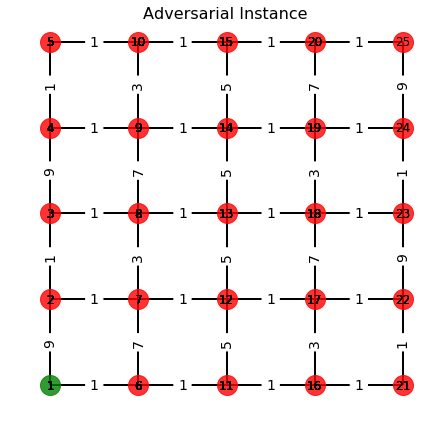

In [28]:
flow,Tree = sp_flow.copy(),sp_tree    
flows = graph.copy()
    
elarge=[(u,v) for (u,v,d) in graph.edges(data=True)]
esmall=[(u,v) for (u,v,d) in graph.edges(data=True) if  ((u,v) not in elarge)]

for i in elarge:
    flows[i[0]][i[1]]['weight'] = int(r[i])

grid = nx.grid_graph([size,size])
pos = {}
j = 1
for i in sorted(grid.nodes()):
    pos[j] = i
    j += 1
fig = plt.figure(1,figsize=(7,7))

# nodes
node_name1 = {}
node_name2 = {}
for node in graph.nodes():
    if node == source:
        node_name1[node]=str(node)
    else:
         node_name2[node]=str(node)
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name1, node_color = 'g')
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name2)

nx.draw_networkx_edges(flows,pos,edgelist=elarge, width=2, edge_color = 'Black', arrows = False)

# labels
node_names = {}
for node in graph.nodes():
    node_names[node]=str(node)
    nx.draw_networkx_labels(flows,pos, labels = node_names)

#only add edge labels to edges in shortest path
new_labels = {}
for i in flows.edges(data = True):
    if (i[:2]) in elarge:
        new_labels[(i[:2])] = i[2]['weight']

nx.draw_networkx_edge_labels(flows,pos, edge_labels = new_labels, font_size=14)
plt.title('Adversarial Instance',fontsize=16)
plt.axis('off')
#plt.savefig('SPT adversarial.pdf', bbox_inches = 'tight' )

(-0.22695381925846225,
 4.202794157320692,
 -0.2276697882118279,
 4.202909345153106)

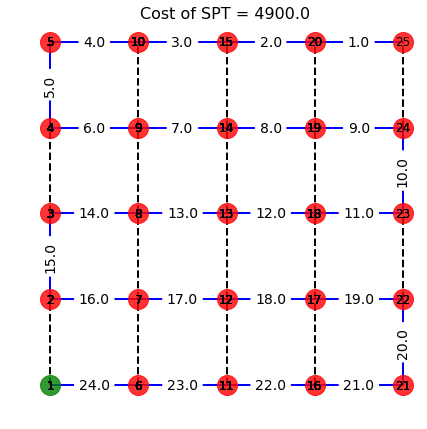

In [44]:
flow,Tree = sp_flow.copy(),sp_tree
    
flows = graph.copy()
    
elarge=[(u,v) for (u,v,d) in graph.edges(data=True) if (u,v) in flow and abs(flow[(u,v)]) > 0]
esmall=[(u,v) for (u,v,d) in graph.edges(data=True) if  ((u,v) not in elarge)]

for i in elarge:
    if flow[(i[0],i[1])]> 0:
        flows[i[0]][i[1]]['weight'] = np.round(flow[(i[0],i[1])],4)
    else:
        flows[i[1]][i[0]]['weight'] = -np.round(flow[(i[0],i[1])],4)

#pos = nx.spectral_layout(graph)
grid = nx.grid_graph([size,size])
pos = {}
j = 1
for i in sorted(grid.nodes()):
    pos[j] = i
    j += 1
fig = plt.figure(1,figsize=(7,7))

# nodes
node_name1 = {}
node_name2 = {}
for node in graph.nodes():
    if node == source:
        node_name1[node]=str(node)
    else:
         node_name2[node]=str(node)
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name1, node_color = 'g')
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name2)

# draw the positive flows edges in solid lines and zero flows edges in dashed lines
nx.draw_networkx_edges(flows,pos,edgelist=elarge, width=2, edge_color = 'blue', arrows = True)
nx.draw_networkx_edges(flows,pos,edgelist=esmall, width=2, style = "dashed", arrows = False)

# labels
node_names = {}
for node in graph.nodes():
    node_names[node]=str(node)
    nx.draw_networkx_labels(flows,pos, labels = node_names)

#only add edge labels to edges in shortest path
new_labels = {}
for i in flows.edges(data = True):
    if (i[:2]) in elarge:
        new_labels[(i[:2])] = i[2]['weight']

nx.draw_networkx_edge_labels(flows,pos, edge_labels = new_labels, font_size=14)
plt.title('Cost of {} = {}'.format('SPT', np.floor(sp_cost)),fontsize=16)
plt.axis('off')
#plt.savefig('LM 5x5 example.pdf', bbox_inches = 'tight' )

(-0.22695381925846225,
 4.202794157320692,
 -0.2276697882118279,
 4.202909345153106)

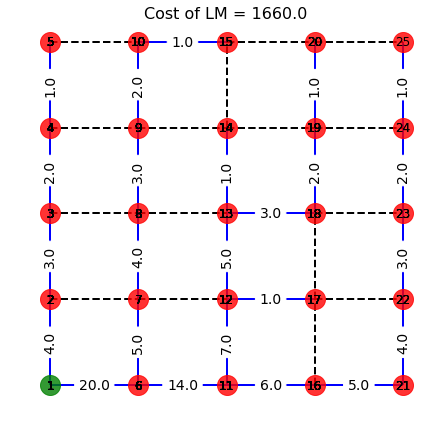

In [45]:
flow,Tree = heuristic_flow.copy(),sp_tree
    
flows = graph.copy()
    
elarge=[(u,v) for (u,v,d) in graph.edges(data=True) if (u,v) in flow and abs(flow[(u,v)]) > 0]
esmall=[(u,v) for (u,v,d) in graph.edges(data=True) if  ((u,v) not in elarge)]

for i in elarge:
    if flow[(i[0],i[1])]> 0:
        flows[i[0]][i[1]]['weight'] = np.round(flow[(i[0],i[1])],4)
    else:
        flows[i[1]][i[0]]['weight'] = -np.round(flow[(i[0],i[1])],4)

#pos = nx.spectral_layout(graph)
grid = nx.grid_graph([size,size])
pos = {}
j = 1
for i in sorted(grid.nodes()):
    pos[j] = i
    j += 1
fig = plt.figure(1,figsize=(7,7))

# nodes
node_name1 = {}
node_name2 = {}
for node in graph.nodes():
    if node == source:
        node_name1[node]=str(node)
    else:
         node_name2[node]=str(node)
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name1, node_color = 'g')
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name2)

# draw the positive flows edges in solid lines and zero flows edges in dashed lines
nx.draw_networkx_edges(flows,pos,edgelist=elarge, width=2, edge_color = 'blue', arrows = True)
nx.draw_networkx_edges(flows,pos,edgelist=esmall, width=2, style = "dashed", arrows = False)

# labels
node_names = {}
for node in graph.nodes():
    node_names[node]=str(node)
    nx.draw_networkx_labels(flows,pos, labels = node_names)

#only add edge labels to edges in shortest path
new_labels = {}
for i in flows.edges(data = True):
    if (i[:2]) in elarge:
        new_labels[(i[:2])] = i[2]['weight']

nx.draw_networkx_edge_labels(flows,pos, edge_labels = new_labels, font_size=14)
plt.title('Cost of {} = {}'.format('LM', np.floor(heuristic_cost)),fontsize=16)
plt.axis('off')
#plt.savefig('LM 5x5 example.pdf', bbox_inches = 'tight' )

(-0.22695381925846225,
 4.202794157320692,
 -0.2276697882118279,
 4.202909345153106)

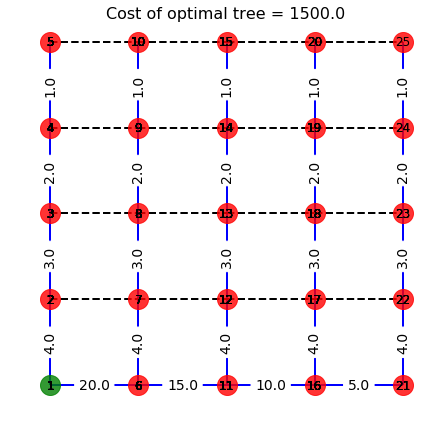

In [46]:
flow  = mip_flow
    
flows = graph.copy()
    
elarge=[(u,v) for (u,v,d) in graph.edges(data=True) if (u,v) in flow and abs(flow[(u,v)]) > 0]
esmall=[(u,v) for (u,v,d) in graph.edges(data=True) if  ((u,v) not in elarge)]

for i in elarge:
    if flow[(i[0],i[1])]> 0:
        flows[i[0]][i[1]]['weight'] = np.round(flow[(i[0],i[1])],4)
    else:
        flows[i[1]][i[0]]['weight'] = -np.round(flow[(i[0],i[1])],4)

#pos = nx.spectral_layout(graph)
grid = nx.grid_graph([size,size])
pos = {}
j = 1
for i in sorted(grid.nodes()):
    pos[j] = i
    j += 1
fig = plt.figure(1,figsize=(7,7)) #Let's draw a big graph so that it is clearer

# nodes
node_name1 = {}
node_name2 = {}
for node in graph.nodes():
    if node == source:
        node_name1[node]=str(node)
    else:
         node_name2[node]=str(node)
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name1, node_color = 'g')
nx.draw_networkx_nodes(flows,pos,node_size=400, alpha = 0.8, nodelist = node_name2)

# draw the positive flows edges in solid lines and zero flows edges in dashed lines
nx.draw_networkx_edges(flows,pos,edgelist=elarge, width=2, edge_color = 'blue', arrows = True)
nx.draw_networkx_edges(flows,pos,edgelist=esmall, width=2, style = "dashed", arrows = False)

# labels
node_names = {}
for node in graph.nodes():
    node_names[node]=str(node)
    nx.draw_networkx_labels(flows,pos, labels = node_names)

#only add edge labels to edges in shortest path
new_labels = {}
for i in flows.edges(data = True):
    if (i[:2]) in elarge:
        new_labels[(i[:2])] = i[2]['weight']

nx.draw_networkx_edge_labels(flows,pos, edge_labels = new_labels, font_size=14)
plt.title('Cost of {} = {}'.format('optimal tree', np.floor(mip_cost)),fontsize=16)
plt.axis('off')
#plt.savefig('OPT 5x5 example.pdf', bbox_inches = 'tight' )

## Code to generate Figure 10

In [ ]:
path = os.path.abspath(os.getcwd())
file_path = path +'/' + 'seed_spt.txt'
f1 = open(file_path, "r")
seed_range = eval(f1.read())
f1.close()

size_range = [5,10,15,25,50,75,100,150]
p_range = [0,0.05,0.1,0.2]


ratios = {}
for size in size_range:
    ratios[size] = {}
    for p in p_range:
        ratios[size][p] = {}
        for q in range(0,25):
            
            np.random.seed(seed_range[size][p][q])
            graph = grid(size)
            n = len(graph.nodes())
            source = 1

            d = {i: 1 for i in graph.nodes() if i!= source}
            plist = dict(zip(list(graph.edges()),np.random.uniform(0,1,2*n**2-2*n)))
            r_prime = {}
            r = {}
            
            graph, b  = create_grid(graph, source,d,p, plist)

            dfs = nx.dfs_tree(graph,source = 1)    
            allsp_prime = nx.single_source_shortest_path_length(dfs, source)

            o = source
            w = source + size*(size - 1)
            for k in range(size-1):
                for i,j in enumerate(range(source + k,w + k+1,5)):
                    if (((j,j+1) not in dfs.edges()) and ((j+1,j) not in dfs.edges())) and (j,j+1) in graph.edges():
                        r_prime[(j,j+1)] = (allsp_prime[j+1] - allsp_prime[j] + 0.01)
                        
            for k in range(size):
                for i,j in enumerate(range(source + k,w + k,5)):
                    if (((j,j+size) not in dfs.edges()) and ((j+size,j) not in dfs.edges())) and (j,j+size) in graph.edges():
                        r_prime[(j,j+size)] = (allsp_prime[j+size] - allsp_prime[j] + 0.01)

            for e in dfs.edges():
                r_prime[(min(e),max(e))] = 1
            
            mu = 0
            sigma = 0.5
            
            noise = np.random.normal(mu,sigma,len(graph.edges))
            
            for i,j in enumerate(list(graph.edges())):
                r[j] = max(r_prime[j] +  noise[i],0.1)
                
            G = r.copy()
            diags1 = sort_vector (r)
            diags2 = 1/sort_vector(r)
            R = np.diag(diags1)
            C = np.diag(diags2)
            dem = -sort_vector(b)

            #dfs output
            sp_tree,sp_flow,sp_cost,sp_time = sp_tree_alg(graph,G,source,b)
            heuristic_flow,heuristic_cost,heuristic_tree,heuristic_time = Heuristic(graph,source,d,G)
            ratios[size][p][alpha[q]] = [sp_cost/heuristic_cost]

In [55]:
#data is also saved in the 'bad_instances1.out' file

f1 = open('bad_instances1.out', "r")
data = eval(f1.read())
f1.close()

def plot_mean_and_CI(x,mean, lb, ub, color_mean=None, color_shading='blue'):
    # plot the shaded range of the confidence intervals\
    plt.plot(x,mean, color_mean)
    plt.fill_between(x, ub, lb, color=color_shading, alpha=.5)
    
new_data = {}
for p in p_range:
    new_data[p] = {}
    for size in size_range:
        new_data[p][size]  = [data[size][p][alpha[j]][0] for j in range(25)]

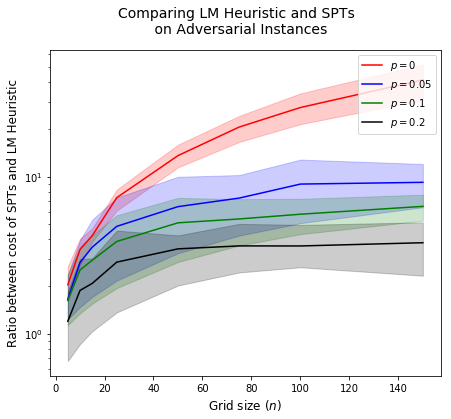

In [56]:
poly1 = 3
poly2  = 2
graph_dic = {0: ['$p = 0$','red'], 0.05:['$p = 0.05$','blue'], 0.1:['$p = 0.1$','green'],0.2:['$p = 0.2$','black']}


for prob in p_range:

    plt.figure(1,figsize=(7,6))

    final_data =   pd.DataFrame.from_dict(new_data[prob], orient = 'index')
    mean = final_data.mean(axis = 1)
    std = final_data.std(ddof=0, axis = 1)
    maxi = final_data.max(axis = 1)
    mini = final_data.min(axis = 1)
    z = np.polyfit(final_data.index, mean, poly1)
    z2 = np.polyfit(final_data.index, mean + 1.65*std, poly1)
    z1 = np.polyfit(final_data.index, mean - 1.65*std, poly2)
    y2 = np.polyval(z,final_data.index)
    y_min = np.polyval(z1,final_data.index)
    y_max = np.polyval(z2,final_data.index)

    plt.plot(final_data.index,mean,color = graph_dic[prob][1], label = '{}'.format(graph_dic[prob][0]))
    plt.fill_between(final_data.index, y_min, (mean + 1.65*std), color=graph_dic[prob][1], alpha=.2)  

plt.xlabel('Grid size ($n$)', fontsize=12)
plt.suptitle ('Comparing LM Heuristic and SPTs \n on Adversarial Instances', fontsize= 14)
plt.ylabel('Ratio between cost of SPTs and LM Heuristic', fontsize= 12)
plt.yscale("log")
plt.legend(loc='upper right')
#plt.savefig('SPT vs LM final log.pdf'.format(size,prob))

## Example of Code to generate performance plots - Figure 7 - Right

In [57]:
def p2f(x):
    return float(x.strip('%'))/100

def read_log(size,instance,method,prob, ext,warm):
    
    '''
    Read Guroby Log files and parse information
    '''
    
    if ext:
        path = os.getcwd() + '\\Outputs_SPT\\ext-formulation-{}\\'.format(method)
    else:
        path = os.getcwd() + '\\Outputs_SPT\\easy-formulation-{}\\'.format(method)
    if ext:
        if warm:
            k = 40
            file_name = path + '{}_{}_{}_{}_ext.log'.format(instance,size,prob,method)
        else:
            k = 40
            file_name = path + '{}_{}_{}_{}_ext.log'.format(instance,size,prob,method)
    else:
        if warm:
            k = 39
            file_name = path + '{}_{}_{}_{}.log'.format(instance,size,prob,method)
        else:
            k = 39
            file_name = path + '{}_{}_{}_{}.log'.format(instance,size,prob,method)
    results = {}

    exact_log = {}
    exact_log['Current Objective'] = []
    exact_log['lower bound'] = []
    exact_log['gap'] = []
    exact_log['time'] = []
    with open(file_name,'r') as f: 
        for i,line in enumerate(f): 
            if i <= k:
                continue
            elif i >= k+1 and line != '\n':
                li = [i for i in line.strip().replace('  ',' ').split(' ') if len(i) > 0 ]
                obj, LB, g, time = li[-5], float(li[-4]),li[-3], float(li[-1][:-1])
                if g == '-':
                    gap = 1
                else:
                    gap = p2f(g)
                if obj == '-':
                    curr_obj = np.nan
                else:
                    curr_obj = float(obj)
                #if time == 0:
                 #   continue
                exact_log['Current Objective'].append(curr_obj)
                exact_log['lower bound'].append(LB)
                exact_log['gap'].append(gap)
                exact_log['time'].append(time)
            else:
                break
        
    return exact_log

def read_out_file(size,instance,method,prob,ext,warm):
    
    '''
    Read the output file contaning the output of algoriths considered in the paper
    '''
    
    if ext:
        path = os.getcwd() + '\\Outputs_SPT\\ext-formulation-{}\\'.format(method)
    else:
        path = os.getcwd() + '\\Outputs_SPT\\easy-formulation-{}'.format(method)
    if ext:
        if warm:
            if method == 'branch_exchange2':
                file_name = path + 'size_{}_{}_{}_{}.out'.format(size,prob,method,instance)
            else:
                file_name = path + 'size_{}_{}_{}_{}.out'.format(size,prob,method,instance)
        else:
            file_name = path + 'size_{}_{}_{}_{}.out'.format(size,prob,method,instance)

    f1 = open(file_name, "r")
    last_lines = f1.readlines()[-23:]
    f1.close()
    data = [ast.literal_eval(i) for i in last_lines]
    inst = ['graph','demand','r','flow_relaxation_cost', 'flow_relaxation_time', 'ride_cost', 'ride_time','ride_flow',
            'ride_energy','dfs_cost' ,'dfs_time','dfs_flow', 'branch_exchange_cost','branch_exchange_time',
            'branch_exchange_flow', 'branch_exchange_costs','heuristic_cost','heuristic_time','heurisic_flow',
            'mip_warm_cost','mip_warm_time','mip_warm_gap','mip_warm_flow']
    results = {}
    for i,j in enumerate(inst):
        if data[i]:
            results[j] = data[i]
    return results

# Example of how to summary of results - last row of Table 1

In [61]:
#Get a summary of statistics on adversarial instances 

dic = {}
final_dic = {}
res = ['heuristic', 'branch_exchange', 'ride','branch_exchange2','spt']
for size in [25]:
    dic[size] = {}
    final_dic[size] = {}
    for p in [0.05]:
        dic[size][p] = {k:{} for k in res}
        final_dic[size][p] = {k:{} for k in res}

        for r in res:
            dic[size][p][r]['cost'] = []
            dic[size][p][r]['time'] = []
            for a in alpha:
                LB1 = min([read_out_file(size,a,k,p,True,True)['mip_warm_cost'] for k in res if (('branch_exchange' not in k) and (k!='dfs') and (k!='spt')) ])
                LB2 = read_out_file(size,a,'branch_exchange',p,True,True)['branch_exchange_cost']
                LB3 = read_out_file(size,a,'branch_exchange2',p,True,True)['branch_exchange_cost']
                LB = min (LB1,LB2,LB3)
                
                if r == 'spt':
                    results = read_out_file(size,a,'heuristic',p,True,True)
                    dic[size][p][r]['cost'].append((results['dfs_cost'.format(r)]/LB - 1))
                    dic[size][p][r]['time'].append(results['dfs_time'.format(r)])
                    
                elif r == 'branch_exchange2':
                    results = read_out_file(size,a,r,p,True,True)
                    dic[size][p][r]['cost'].append((results['{}_cost'.format('branch_exchange')]/LB - 1))
                    dic[size][p][r]['time'].append(results['{}_time'.format('branch_exchange')])
                else:
                    results = read_out_file(size,a,r,p,True,True)
                    dic[size][p][r]['cost'].append((results['{}_cost'.format(r)]/LB - 1))
                    dic[size][p][r]['time'].append(results['{}_time'.format(r)])
        
        dic[size][p]['best'] = np.minimum(dic[size][p]['spt']['cost'],dic[size][p]['heuristic']['cost'])

        for r in res:
            final_dic[size][p][r]['cost'] = np.mean(dic[size][p][r]['cost'])
            final_dic[size][p][r]['time'] = np.mean(dic[size][p][r]['time'])
            
        final_dic[size][p]['best'] = np.mean(dic[size][p]['best'])

In [70]:
final_dic[25][0.05]

{'heuristic': {'cost': 0.8024261557214338, 'time': 0.7290236400000001},
 'branch_exchange': {'cost': 1.611961216358335, 'time': 86548.64537708},
 'ride': {'cost': 10.918524882067908, 'time': 133.95131036},
 'branch_exchange2': {'cost': 0.18630942631850422, 'time': 90138.64559604},
 'spt': {'cost': 7.149542578877158, 'time': 0.09995496},
 'best': 0.8024261557214338}

In [59]:
#read all data from output files and put into necessary format for plotting

methods,IP= (['heuristic', 'ride', 'branch_exchange','branch_exchange2'], ['easy', 'ext'])
methods1 = ['heuristic', 'ride']
dfs = {}
new_data = {}
for size in [25]:
    dfs[size] = {}
    new_data[size] = {}
    for prob in [0.05]:
        dfs[size][prob] = {}
        new_data[size][prob] = {}
        gap_data= {}
        time_data = {}
        obj_data = {}
        for m in methods:
            new_data[size][prob][m] = {}
            dfs[size][prob][m] = {}
            gap_data[m] = {}
            time_data[m] = {}
            obj_data[m] = {}
            times = []
            if m != 'branch_exchange' and m != 'branch_exchange2':
                for inst in alpha:
                    #LB = max([read_log(size,inst,k,prob, True,True)['lower bound'][-1] for k in methods1])
                    LB1 = min([read_out_file(size,inst,k,p,True,True)['mip_warm_cost'] for k in res if (('branch_exchange' not in k) and (k!='dfs') and (k!='spt')) ])
                    LB2 = read_out_file(size,inst,'branch_exchange',p,True,True)['branch_exchange_cost']
                    LB3 = read_out_file(size,inst,'branch_exchange2',p,True,True)['branch_exchange_cost']
                    LB = min (LB1,LB2,LB3)
                    results = read_out_file(size,inst,m,prob,True,True)
                    dfs[size][prob][m][inst] = {}
                    new_data[size][prob][m] = {}
                    ext = True
                    warm = True
                    data = read_log(size,inst,m,prob, ext,warm)
                    t = results['{}_time'.format(m)]
                    time_data[m][inst] =  np.array(data['time']) + t
                    obj_data[m][inst] = np.array(data['Current Objective'])/LB - 1
                    times.append(t)

                    time_data[m][inst] = np.insert(time_data[m][inst], 0, results['{}_time'.format(m)])
                    obj_data[m][inst] = np.insert(obj_data[m][inst], 0, results['{}_cost'.format(m)])

                    df = pd.DataFrame(np.array(obj_data[m][inst]))
                    df.index = time_data[m][inst]
                    df.index.name = 'timestamp'
                    df.columns =  ['instance {}'.format(inst)]
                    df = df.loc[~df.index.duplicated(keep='first')]
                    dfs[size][prob][m][inst] = df
                    
            else:
                for inst in alpha:
                    LB1 = min([read_out_file(size,inst,k,p,True,True)['mip_warm_cost'] for k in res if (('branch_exchange' not in k) and (k!='dfs') and (k!='spt')) ])
                    LB2 = read_out_file(size,inst,'branch_exchange',p,True,True)['branch_exchange_cost']
                    LB3 = read_out_file(size,inst,'branch_exchange2',p,True,True)['branch_exchange_cost']
                    LB = min (LB1,LB2,LB3)
                    results = read_out_file(size,inst,m,prob,True,True)
                    dfs[size][prob][m][inst] = {}
                    costs = results['{}_costs'.format('branch_exchange')] 
                    costs_sorted = [k for k in sorted(list(costs.keys()),reverse=True)]
                    obj_data[m][inst] = np.array(costs_sorted)/LB - 1
                    time_data[m][inst] = np.array([costs[k] for k in costs_sorted])
                    df = pd.DataFrame(np.array(obj_data[m][inst]))
                    df.index = time_data[m][inst]
                    df.index.name = 'timestamp'
                    df.columns =  ['instance {}'.format(inst)]
                    df = df.loc[~df.index.duplicated(keep='first')]
                    dfs[size][prob][m][inst] = df
                    
            max_time = 86400
            if m != 'branch_exchange' and m != 'branch_exchange2':
                t = max(times)   
            else:
                t= 5
            for s in range(20 , max_time +20,240):
                new_data[size][prob][m][s] = []
                for inst in dfs[size][prob][m].keys():
                    if s in dfs[size][prob][m][inst]['instance {}'.format(inst)].index:
                        new_data[size][prob][m][s].append(float(dfs[size][prob][m][inst]['instance {}'.format(inst)].loc[s]))
                    if s <= t:
                        continue
                    elif s >= max_time:
                        c = dfs[size][prob][m][inst]['instance {}'.format(inst)].loc[dfs[size][prob][m][inst]['instance {}'.format(inst)].index[-1]]
                        new_data[size][prob][m][s].append(c)
                    else:
                        a = dfs[size][prob][m][inst]['instance {}'.format(inst)].index[dfs[size][prob][m][inst]['instance {}'.format(inst)].index > s].min()
                        b = dfs[size][prob][m][inst]['instance {}'.format(inst)].index[dfs[size][prob][m][inst]['instance {}'.format(inst)].index < s].max()
                        new_data[size][prob][m][s].append(float(dfs[size][prob][m][inst]['instance {}'.format(inst)].loc[a] + \
                        (s-a)*(dfs[size][prob][m][inst]['instance {}'.format(inst)].loc[b] - dfs[size][prob][m][inst]['instance {}'.format(inst)].loc[a])/(b-a)))

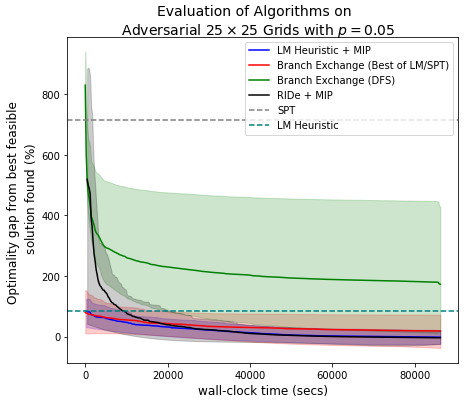

In [62]:
poly1 = 3
poly2  = 4
methods,IP= (['spt','heuristic', 'branch_exchange2', 'branch_exchange', 'ride'], ['easy', 'ext'])
methods1 = ['spt','heuristic','branch_exchange',]
graph_dic = {'dfs': ['DFS','red'], 'heuristic':['LM Heuristic + MIP','blue'], 'branch_exchange':['Branch Exchange (DFS)','green'], \
             'branch_exchange2':['Branch Exchange (Best of LM/SPT)','red'], 'ride':['RIDe + MIP','black']}

spt_cost = final_dic[size][0.05]['spt']['cost']
best_cost = final_dic[size][0.05]['best']

for size in [25]:
    for prob in [0.05]:
        plt.figure(1,figsize=(7,6))
        mean_heuristic = None
        mean_ride = None
        mean_branch_exchange = None
        for m in methods:
            if m!='spt':
                if m =='heuristic':
                    final_data =   pd.DataFrame.from_dict(new_data[size][prob][m], orient = 'index')[1:]
                else:
                    final_data =   pd.DataFrame.from_dict(new_data[size][prob][m], orient = 'index')
                final_data = final_data.dropna(how='all') 
                mean = final_data.mean(axis = 1)
                if m == 'heuristic':
                    mean_heuristic= mean.iloc[0]
                elif m == 'ride':
                    mean_ride= mean.iloc[0]
                elif m == 'branch_exchange':
                    mean = mean
                    
                std = final_data.std(ddof=0, axis = 1)
                maxi = final_data.max(axis = 1)
                mini = final_data.min(axis = 1)
                z = np.polyfit(final_data.index, mean, poly1)
                z2 = np.polyfit(final_data.index, mean + 1.65*std, poly1)
                z1 = np.polyfit(final_data.index, mean - 1.65*std, poly2)
                y2 = np.polyval(z,final_data.index)
                y_min = np.polyval(z1,final_data.index)
                y_max = np.polyval(z2,final_data.index)

                if m == 'branch_exchange':
                    plt.plot(final_data.index,mean*100,color = graph_dic[m][1], label = '{}'.format(graph_dic[m][0]))
                    plt.fill_between(final_data.index, (mean -std)*100 + 100, (mean +std)*100, color=graph_dic[m][1], alpha=.2)
                else:
                    plt.plot(final_data.index,mean*100,color = graph_dic[m][1], label = '{}'.format(graph_dic[m][0]))
                    plt.fill_between(final_data.index, y_min*100, (mean +1.65*std)*100, color=graph_dic[m][1], alpha=.2)
                
        
        plt.axhline(spt_cost*100,  color='gray', linestyle='--', label = 'SPT')
        plt.axhline(mean_heuristic*100,  color='teal', linestyle='--', label = 'LM Heuristic')
        
        plt.xlabel('wall-clock time (secs)', fontsize=12)
        plt.suptitle ('Evaluation of Algorithms on \n Adversarial ${}\\times{}$ Grids with $p = {}$'.format(size,size,prob)\
                      ,y=0.95, fontsize= 14)
        plt.ylabel('Optimality gap from best feasible \n solution found ($\\%$)', fontsize= 12)
        plt.legend(loc='upper right')
        #plt.savefig('final_plot_{}_{}_paper_spt_adver.pdf'.format(size,prob))